### IMPORT

In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain 
import folium

### CREAZIONE DEL FILE 'completo.csv' NON ESEGUIRE

In [2]:
mappa_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/dataset/mappa2.csv')
treni_df = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/dataset/treni_modificati.csv', on_bad_lines='skip')

# Rimuovi le righe dove la categoria è 'MET'
treni_df = treni_df[treni_df['categoria'] != 'MET']
treni = treni_df[['categoria', 'stazPart', 'stazArr']].copy()

# Funzione per normalizzare i nomi delle stazioni
def normalize_station_name(station_name):
    if isinstance(station_name, str):
        return station_name.upper()
    return station_name

# Normalizza i nomi delle stazioni di partenza e arrivo
treni['stazPart'] = treni['stazPart'].apply(normalize_station_name)
treni['stazArr'] = treni['stazArr'].apply(normalize_station_name)
mappa_df['Nome'] = mappa_df['Nome'].apply(normalize_station_name)

# Rinominare le colonne di mappa_df per evitare conflitti durante il merge tra partenze e arrivi
mappa_df_part = mappa_df.rename(columns={
    'Nome': 'stazPart', 'Comune': 'Comune_part', 'Provincia': 'Provincia_part',
    'Regione': 'Regione_part', 'Longitudine': 'Longitudine_part', 'Latitudine': 'Latitudine_part'
})
mappa_df_arr = mappa_df.rename(columns={
    'Nome': 'stazArr', 'Comune': 'Comune_arr', 'Provincia': 'Provincia_arr',
    'Regione': 'Regione_arr', 'Longitudine': 'Longitudine_arr', 'Latitudine': 'Latitudine_arr'
})
merged_df = treni \
    .merge(mappa_df_part, on='stazPart', how='inner') \
    .merge(mappa_df_arr, on='stazArr', how='inner')

# Rimuovere le colonne Unnamed: 0_x e Unnamed: 0_y se presenti
merged_df = merged_df.loc[:, ~merged_df.columns.str.contains('^Unnamed')]

# Leggi il file completo
completo = merged_df

lettura file 'completo.csv' creato nella sezione sopra

In [3]:
completo = pd.read_csv('/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/dataset/completo.csv', on_bad_lines='skip')

## GRAFO E MISURAZIONI

In [4]:
# Creiamo un grafo vuoto
G = nx.Graph()

# Contiamo il numero di treni tra ogni coppia di comuni
edge_weights = completo.groupby(['Comune_part', 'Comune_arr']).size().reset_index(name='counts')

# Aggiungiamo gli archi al grafo con i pesi corrispondenti
for index, row in edge_weights.iterrows():
    G.add_edge(row['Comune_part'], row['Comune_arr'], weight=row['counts'])

# Rimuoviamo i self-loop
G.remove_edges_from(nx.selfloop_edges(G))

# calcolo delle misurazioni
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)
closeness_centrality = nx.closeness_centrality(G)
clustering_coefficient = nx.clustering(G)
density = nx.density(G)

if nx.is_connected(G):
    avg_path_length = nx.average_shortest_path_length(G)
    diameter = nx.diameter(G)
else:
    avg_path_length = None
    diameter = None

connected_components = list(nx.connected_components(G))
connectedness = len(connected_components)

core_number = nx.core_number(G)
assortativity = nx.degree_assortativity_coefficient(G)
partition = community_louvain.best_partition(G)
modularity = community_louvain.modularity(partition, G)
bridges = list(nx.bridges(G))

# stampa delle metriche
print("Degree Centrality:", degree_centrality)
print("Betweenness Centrality:", betweenness_centrality)
print("Eigenvector Centrality:", eigenvector_centrality)
print("Closeness Centrality:", closeness_centrality)
print("Clustering Coefficient:", clustering_coefficient)
print("Density:", density)
print("Number of Connected Components:", connectedness)
print("Core Numbers:", core_number)
print("Assortativity:", assortativity)
print("Modularity:", modularity)
print("Bridges:", bridges)

Degree Centrality: {'ALA': 0.006060606060606061, 'TRENTO': 0.03636363636363636, 'ALBA': 0.006060606060606061, 'ASTI': 0.012121212121212121, 'ANCONA': 0.06666666666666667, 'FABRIANO': 0.01818181818181818, 'FOLIGNO': 0.03636363636363636, 'ISCHITELLA': 0.006060606060606061, 'JESI': 0.006060606060606061, 'MACERATA': 0.012121212121212121, 'PARMA': 0.04242424242424243, 'PESARO': 0.030303030303030304, 'PIACENZA': 0.04242424242424243, 'RIMINI': 0.07878787878787878, 'ROMA': 0.13333333333333333, 'SULMONA': 0.01818181818181818, 'AREZZO': 0.01818181818181818, 'CATANZARO': 0.01818181818181818, 'PISTOIA': 0.012121212121212121, 'PONTASSIEVE': 0.01818181818181818, 'ARONA': 0.01818181818181818, 'DOMODOSSOLA': 0.012121212121212121, 'MILANO': 0.030303030303030304, 'NOVARA': 0.05454545454545454, 'ASSORO': 0.006060606060606061, 'VOGHERA': 0.024242424242424242, 'AVEZZANO': 0.01818181818181818, 'CAPISTRELLO': 0.006060606060606061, 'CASSINO': 0.01818181818181818, 'BARLETTA': 0.012121212121212121, 'FASANO': 0.

### LAYOUT DEL GRAFO CHE ABBIAMO DESCRITTO

(-1.202351075878556,
 1.1987799766580394,
 -1.207527564569136,
 1.1839805604656684)

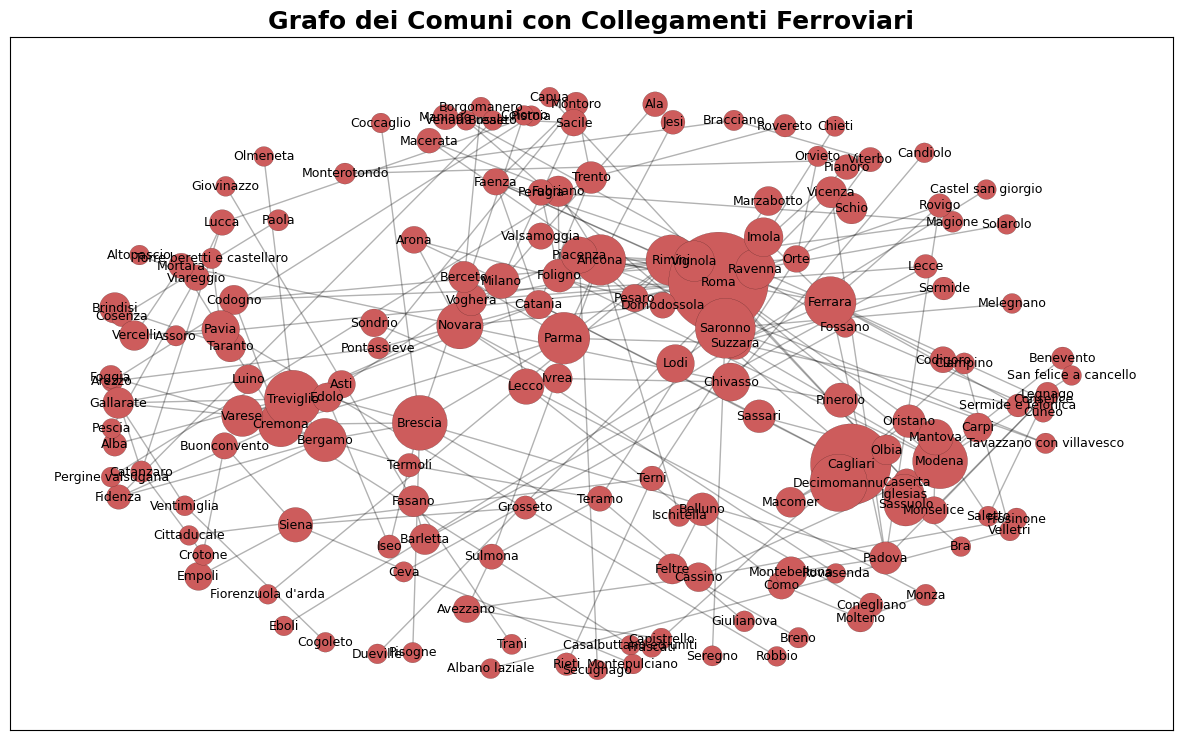

In [5]:
# Posizioni dei nodi nel layout
pos = nx.spring_layout(G, k=1.3)
# Calcolo delle dimensioni dei nodi in base alla somma dei pesi degli archi entranti
in_weight_sum = dict(G.degree(weight='weight'))
node_size = [200 + in_weight_sum[node] * 3 for node in G.nodes()]  

# Grafo
plt.figure(figsize=(15, 9))
#nodi
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color='indianred', edgecolors='black', linewidths=0.1)
#archi
edges = nx.draw_networkx_edges(G, pos, alpha=0.3)
#labels
labels = {node: node.capitalize() for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels, font_size=9, font_family='sans-serif')
#titolo
plt.title('Grafo dei Comuni con Collegamenti Ferroviari', fontsize=18, fontweight='bold')
plt.axis('on') #off
#plt.show() ciao

### CENNI TEORICI (PERCHE ABBIAMO SCELTO QUELLE METRICHE) DA SCRIVERE NELLA RELAZIONE

In [ ]:
'''

1. Centralità (Degree, Betweenness, Eigenvector, Closeness)
Scopo: Identificare i nodi (comuni) più importanti o influenti nella rete.
Misurazioni:
Degree Centrality: Indica quanti collegamenti ha un nodo. Può rivelare le stazioni ferroviarie con il maggior numero di connessioni dirette.
Betweenness Centrality: Misura il numero di volte che un nodo funge da intermediario nei cammini minimi. Utile per identificare nodi critici che, se rimossi, potrebbero causare disconnessione della rete.
Eigenvector Centrality: Valuta l'importanza di un nodo basata sulla centralità dei suoi vicini. Può identificare le stazioni più influenti in un contesto globale.
Closeness Centrality: Indica quanto un nodo è "vicino" a tutti gli altri nodi. Utile per capire quali stazioni hanno accesso rapido al resto della rete.

2. Coefficienti di Clustering e Densità
Scopo: Analizzare la coesione e la compattezza della rete.
Misurazioni:
Clustering Coefficient: Misura la tendenza dei nodi a formare cluster o gruppi. Utile per capire quanto la rete è segmentata in comunità o sub-reti.
Density: Rapporto tra il numero di archi presenti e il numero massimo possibile di archi. Indica quanto la rete è densamente connessa.

3. Analisi delle Componenti Connesse
Scopo: Identificare e analizzare le componenti connesse della rete per capire come la rete potrebbe frammentarsi.
Misurazioni:
Connected Components: Numero di componenti connesse nella rete. Utile per identificare isole o subnet isolate.

4. Core-Periphery Analysis
Scopo: Identificare la struttura core-periphery della rete.
Misurazioni:
Core Number: Utilizzare l'algoritmo di k-core per identificare il nucleo centrale della rete.

5. Assortativity
Scopo: Valutare se nodi con simili proprietà (ad esempio, grado) tendono a collegarsi tra loro.
Misurazioni:
Degree Assortativity Coefficient: Misura la correlazione tra i gradi dei nodi connessi. Può indicare se stazioni centrali tendono a collegarsi con altre stazioni centrali.

6. Modularity e Community Detection
Scopo: Identificare comunità o gruppi di nodi fortemente connessi all'interno della rete.
Misurazioni:
Modularity: Misura la forza della divisione della rete in moduli o comunità. Utilizzando algoritmi di rilevazione delle comunità come Louvain.

'''

## MAPPA DELL'ITALIA

In [7]:
#rimuovo i comuni duplicati
completo = completo.drop_duplicates()

# Creare una mappa centrata sull'Italia
m = folium.Map(location=[41.8719, 12.5674], zoom_start=6, zoom_control=False, scrollWheelZoom=False)
geojson_data= '/Users/riccardospini/Desktop/unibo/SECONDO_ANNO/SNA/progetto/italy.geojson'

# Aggiungere i confini delle regioni italiane con bordo nero
folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        'color': 'black',
        'weight': 0.7
    }
).add_to(m)

# Aggiungere i punti alla mappa
for idx, row in completo.iterrows():
    folium.CircleMarker(
        location=[row['Latitudine_part'], row['Longitudine_part']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)
    folium.CircleMarker(
        location=[row['Latitudine_arr'], row['Longitudine_arr']],
        radius=3,
        color='red',
        fill=True,
        fill_color='red'
    ).add_to(m)

# Aggiungere le linee tra i punti di partenza e arrivo
for idx, row in completo.iterrows():
    folium.PolyLine(
        locations=[[row['Latitudine_part'], row['Longitudine_part']], [row['Latitudine_arr'], row['Longitudine_arr']]],
        color='blue',
        weight=1
    ).add_to(m)

m

# TODO CHECKLIST

- capire bene i risultati
- migliorare la mappa dell'italia, in particolar modo gli archi (confido in te super franci debuggatore)
- aggiungere grafici (istogrammi)